<a href="https://colab.research.google.com/github/ashikshafi08/Learning-Fastai/blob/main/Walk%20With%20Fastai%20(Zach%20Mueller)%20/%20WWF_Lesson_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fastai wwf -q --upgrade
from wwf.utils import state_versions
state_versions(['fastai', 'fastcore', 'wwf'])

     |████████████████████████████████| 194kB 6.7MB/s 
     |████████████████████████████████| 12.8MB 189kB/s 
     |████████████████████████████████| 776.8MB 24kB/s 
     |████████████████████████████████| 61kB 7.5MB/s 
     |████████████████████████████████| 296kB 37.6MB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.



---
This article is also a Jupyter Notebook available to be run from the top down. There
will be code snippets that you can then run in any environment.

Below are the versions of `fastai`, `fastcore`, and `wwf` currently running at the time of writing this:
* `fastai`: 2.3.0 
* `fastcore`: 1.3.19 
* `wwf`: 0.0.13 
---

In [3]:
# We're going to use the basics , callbacks and vision packages today 
from fastai.vision.all import * 
from fastai.callback.all import * 
from fastai.basics import * 

In [6]:
# Or we can type out every single things we're going to use here (Just a Practice, import what you need)

# Essentials to process our workflow
import numpy as np 
from fastcore.xtras import Path # properties of Pathlib module 

# Callbacks we need to help our model fit
from fastai.callback.fp16 import to_fp16
from fastai.callback.schedule import fit_one_cycle , lr_find 

# Imports to structure how our data is befoe modelling and some transforms. 
from fastai.data.block import CategoryBlock , DataBlock 
from fastai.data.external import untar_data , URLs 
from fastai.data.transforms import get_image_files , Normalize , RandomSplitter , RegexLabeller

# For visualizing our results and a Learner (to train our model)
from fastai.interpret import ClassificationInterpretation
from fastai.learner import Learner #  properties to Learner including `save`, `load`, `freeze`, and `unfreeze` 

# Metric to rate our performance of the model 
from fastai.metrics import error_rate 

# Some of the augmentation and stats for our model  
from fastai.vision.augment import aug_transforms , RandomResizedCrop
from fastai.vision.core import imagenet_stats 
from fastai.vision.data import ImageBlock , ImageDataLoaders
from fastai.vision.learner import cnn_learner

# Models we need to learn patterns in our data 
from torchvision.models.resnet import resnet34 , resnet50

Overall process using machine learning models and fastai: 
- Make our `DataBlock` and `DataLoaders`
- Make a `Learner` with some equips such as `callbacks`
- Train it

In [7]:
# To know what a function does 
help(untar_data)

Help on function untar_data in module fastai.data.external:

untar_data(url, fname=None, dest=None, c_key='data', force_download=False, extract_func=<function file_extract at 0x7fc756028050>, timeout=4)
    Download `url` to `fname` if `dest` doesn't exist, and un-tgz or unzip to folder `dest`.



The dataset we're going to use is Pets, let's download it from the S3 bucket using untar_data

In [8]:
# Downloading the dataset 
path = untar_data(URLs.PETS)

This data contains, 12 breeds of Cats and 25 different breeds of Dogs. We're going to train our model and make it classify between different Pet Breeds. 

In [10]:
# Set our seed for reproducibility 
np.random.seed(42)

In [11]:
# Checking what's in the path ? 
path.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/images'),Path('/root/.fastai/data/oxford-iiit-pet/annotations')]

We need to build our `DataLoaders` for that we need, 
- path 
- our filenames of our data 
- a pattern to extract our labels. 

In [12]:
fnames = get_image_files(path/'images') # Getting the filenames of the images 
pat = r'(.+)_\d+.jpg$' # regex pattern for our labels

Applying some data augmentation to our model, to improve it's sense of generalization. 

In [13]:
# Getting our augmentations in line
item_tfms = RandomResizedCrop(460 , min_scale = 0.75 , ratio = (1. , 1.))
batch_tfms = [*aug_transforms(size = 224 , max_warp= 0) , Normalize.from_stats(*imagenet_stats)]

# Our batch size, the num of mini-batches (train, valid) we wanna split 
bs = 64

`ImageDataLoaders` --> Highest level API 

In [17]:
help(ImageDataLoaders.from_name_re)

Help on method from_name_re in module fastai.vision.data:

from_name_re(path, fnames, pat, bs=64, val_bs=None, shuffle=True, device=None) method of builtins.type instance
    Create from the name attrs of `fnames` in `path`s with re expression `pat`



In [20]:
# Creating the ImageDataLoaders (High Level API)
dls = ImageDataLoaders.from_name_re(path , fnames , pat , 
                                    batch_tfms = batch_tfms , item_tfms = item_tfms , bs = bs)

Now re-building the whole thing with an `DataBlock`.

We'll need to define what our input and outputs should be (An Image and a Category for classification), how to get our items, how to split our data, how to extract our labels, and our augmentation as before

In [24]:
# Using DataBlock (Mid Level API)
pets = DataBlock(blocks = (ImageBlock , CategoryBlock) , 
                 get_items = get_image_files , 
                 splitter = RandomSplitter() , 
                 get_y = RegexLabeller(pat = r'/([^/]+)_\d+.*') , 
                 item_tfms = item_tfms , 
                 batch_tfms = batch_tfms)

In [25]:
# Defining the path were our images are situated 
path_im = path/'images'

In [26]:
# Putting everything into a dataloader 
dls = pets.dataloaders(path_im , bs = 64)

We can take a look at a batch of our images using show_batch and pass in a maximum number of images to show, and how large we want to view them as

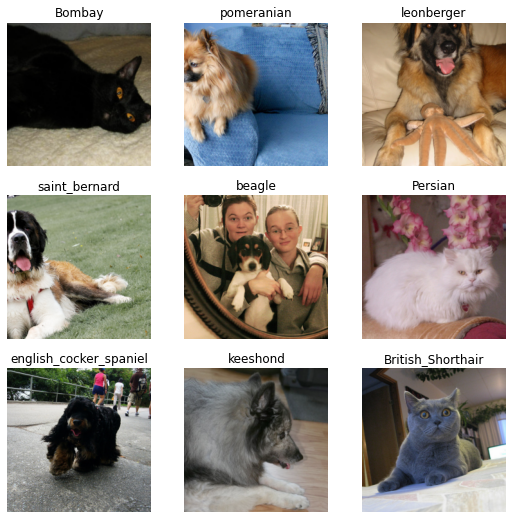

In [27]:
# Visualizing our batch of images 
dls.show_batch(max_n = 9)

To check how many classes we have and the names of those class we can use `dls.vocab`

In [33]:
# Our class names / How many classes are there? (should be 37)
print(dls.vocab)
print(f'\n There are {len(dls.vocab)} classes in our dataloaders')

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']

There are 37 classes in our dataloaders


We can even get the index of the class names stored in our dataloaders by using `dls.vocab.o2i`

In [39]:
# Getting dict of index and class names 
dls.vocab.o2i

{'Abyssinian': 0,
 'Bengal': 1,
 'Birman': 2,
 'Bombay': 3,
 'British_Shorthair': 4,
 'Egyptian_Mau': 5,
 'Maine_Coon': 6,
 'Persian': 7,
 'Ragdoll': 8,
 'Russian_Blue': 9,
 'Siamese': 10,
 'Sphynx': 11,
 'american_bulldog': 12,
 'american_pit_bull_terrier': 13,
 'basset_hound': 14,
 'beagle': 15,
 'boxer': 16,
 'chihuahua': 17,
 'english_cocker_spaniel': 18,
 'english_setter': 19,
 'german_shorthaired': 20,
 'great_pyrenees': 21,
 'havanese': 22,
 'japanese_chin': 23,
 'keeshond': 24,
 'leonberger': 25,
 'miniature_pinscher': 26,
 'newfoundland': 27,
 'pomeranian': 28,
 'pug': 29,
 'saint_bernard': 30,
 'samoyed': 31,
 'scottish_terrier': 32,
 'shiba_inu': 33,
 'staffordshire_bull_terrier': 34,
 'wheaten_terrier': 35,
 'yorkshire_terrier': 36}

Using mixed precision and creating our model using `cnn_learner`

In [40]:
learn = cnn_learner(dls , resnet34 , pretrained= True , metrics=error_rate).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


Now we can train our model for 4 cycles through our data. 
- Loss Function used is `CrossEntropyLossFlat`
- Optimizer used is `Adam`

In [41]:
# Fitting / training our model 
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.948578,0.365803,0.112991,01:25
1,0.684566,0.250337,0.079838,01:24
2,0.391237,0.230688,0.079161,01:23
3,0.286442,0.218381,0.074425,01:21


Saving the weights of our trained model `learn`, incase if Colab shoots an error sometime.

In [42]:
learn.save('stage1') 

Path('models/stage1.pth')

The model has been saved inside the folder `models` with an extension `.pth`